# Objective

The objective is to analyze a multi-class dataset to determine if it is linearly separable in its original
feature space, in the feature space defined by Principal Component Analysis (PCA), in a new feature space with very high
dimensions, or in all three feature spaces. To this end, we will use a multi-class perceptron to determine if the data is linearly
separable and a non-linear version of PCA to project the dataset onto a very high-dimensional feature space.

## The Data Set

The Speaker Accent Recognition DataSet from the UCI Machine Learning Repository is used.
The dataset contains 6 classes and 329 samples, where each class refers to a possible
accent. The classes are: {ES, FR, GE, IT, UK, US} for the Spanish (ES), French (FR), German (GE), Italian (IT), British (UK),
and American (US) accents. Each sample is represented by a 12d feature vector obtained by extracting the Mel-Frequency
Cepstral Coefficients on the original time domain soundtrack of the maximum 1s of reading of a word.

### Loading the data

The data is downloaded as a .data file. We use will pandas to read the data with commas as a seperator, which we will then store as a variable.

In [3]:
import pandas as pd

In [4]:
# read data and store as a dataframe
df = pd.read_csv('accent-mfcc-data-1.data', sep=",", header = None)

In [3]:
# showcase part of the data set for reference
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,ES,7.071476,-6.512900,7.650800,11.150783,-7.657312,12.484021,-11.709772,3.426596,1.462715,-2.812753,0.866538,-5.244274
1,ES,10.982967,-5.157445,3.952060,11.529381,-7.638047,12.136098,-12.036247,3.491943,0.595441,-4.508811,2.332147,-6.221857
2,ES,7.827108,-5.477472,7.816257,9.187592,-7.172511,11.715299,-13.847214,4.574075,-1.687559,-7.204041,-0.011847,-6.463144
3,ES,6.744083,-5.688920,6.546789,9.000183,-6.924963,11.710766,-12.374388,6.169879,-0.544747,-6.019237,1.358559,-6.356441
4,ES,5.836843,-5.326557,7.472265,8.847440,-6.773244,12.677218,-12.315061,4.416344,0.193500,-3.644812,2.151239,-6.816310


Unlike conventional data sets, the class labels can be found on the first column, which is column 0. Another feature to point out is that there are no formal headers or row names. Row and column indexes are used instead.

### Visualising the data in a 2D feature space

We will use a Linear PCA to be able to properly display the data in a 2D feature space.

#### Defining a PCA function through SVD decomposition

In [5]:
import numpy as np

In [5]:
# function that decomposes a dataset to singular values
def decompose(scaled_df):

    # apply SVD decomposition of centred data
    U, S, Vt = np.linalg.svd(scaled_df, full_matrices = False)
    
    return U, S, Vt

In [6]:
# split training and target data - will be used more later in the report
train = df.iloc[: , 1:]
target = df.iloc[:, 0]

# centre data
scaled_train = train - np.mean(train, axis = 0)

# decompose with SVD
U, S, Vt = decompose(scaled_train)

#### Dimensionality reduction

In [6]:
import matplotlib.pyplot as plt

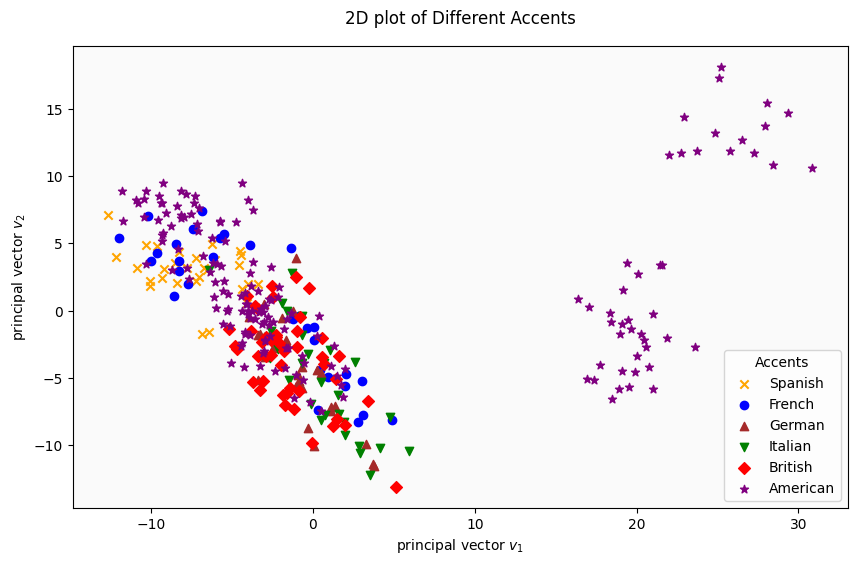

In [8]:
# projecting data points onto principal components
P = np.matmul(scaled_train.to_numpy(), Vt.T)


# grouping indexes of the same target together
idx_es = np.where(target=='ES')[0]
idx_fr = np.where(target=='FR')[0]
idx_ge = np.where(target=='GE')[0]
idx_it = np.where(target=='IT')[0]
idx_uk = np.where(target=='UK')[0]
idx_us = np.where(target=='US')[0]


# labelling coordinates by getting top PCs
es_x = P[idx_es, 0]
es_y = P[idx_es, 1]

fr_x = P[idx_fr, 0]
fr_y = P[idx_fr, 1]

ge_x = P[idx_ge, 0]
ge_y = P[idx_ge, 1]

it_x = P[idx_it, 0]
it_y = P[idx_it, 1]

uk_x = P[idx_uk, 0]
uk_y = P[idx_uk, 1]

us_x = P[idx_us, 0]
us_y = P[idx_us, 1]


# plotting coordinates
fig1 = plt.figure(figsize=(10.0,6.0))
plt.scatter(es_x, es_y, marker = 'x', color = "orange", label = "Spanish")
plt.scatter(fr_x, fr_y, marker = 'o', color = "blue", label = "French")
plt.scatter(ge_x, ge_y, marker = '^', color = "brown", label = "German")
plt.scatter(it_x, it_y, marker = 'v', color = "green", label = "Italian")
plt.scatter(uk_x, uk_y, marker = 'D', color = "red", label = "British")
plt.scatter(us_x, us_y, marker = '*', color = "purple", label = "American")

plt.legend(loc='lower right', title="Accents", scatterpoints=1, fontsize=10)

ax = plt.gca()

ax.set_xlabel(r'principal vector $v_{1}$')
ax.set_ylabel(r'principal vector $v_{2}$')
ax.set_title('2D plot of Different Accents',fontsize=12, y=1.03)
ax.set_facecolor('0.98')

plt.show()

Judging from the 2D plot of the data generated with the top 2 PCs as its basis, we can see that there is no linear function that can seperate a class from other classes, mainly due to the leftmost cluster of points. The leftmost cluster contains all sorts of points spread all over each other, and all class labels can be associated with at least one point inside the aforementioned cluster. The other two clusters are clusters of points associating with a single class label: American. It would be possible to find such a function seperating American and non American points if the leftmost cluster doest not contain any point associating to the American accent, which is not the case. Even if it were the case, it is unlikely that we can find weights for other classes such that it is linearly seperable. Therefore from visual inspection it can be concluded that the data set visualised with 2d feature vectors is linearly non-separable.

## Designing a multi-class perceptron

### Implementing a linear classifier

In [9]:
# perceptron function based on labs
def Perceptron(X, Y, wt):
    for i in range(X.shape[1]):
        xi = X[:, i]
        yi = Y[i]
        e = np.sign(np.matmul(wt, xi)) - yi
        if e != 0:
            wt = wt + yi * xi
    return wt

### Using a linear classifier to implement a multi-class classifier

We will create a MultiPerceptron class which has a fit, predict, and accuracy function. 

In [10]:
import random

In [11]:
class MultiPerceptron:

    # function trains the data set
    def fit(self, train, target, verbose):
        classes = np.unique(target)
        weights = np.empty(shape=(classes.shape[0], train.shape[1] + 1))

        # configure inputs for base case
        feature_matrix = train.T
        X = np.insert(feature_matrix, 0, [1 for i in range(0, feature_matrix.shape[1])], axis = 0) # add bias

        # base case - obtain intial weights through the 'one-vs-all' method
        idx = 0
        for c in classes:

            # Converts labels to a proper binary class labels
            Yc = [1 if label == c else -1 for label in target] 

            # Gets initial weights from training with binary classifiers
            wt = Perceptron(X, Yc, np.zeros(X.shape[0]))
            weights[idx] = wt
            idx += 1

        # iterative step - refine weights
        for _ in range(0, 10):
            for i in random.sample(list(range(train.shape[0])), k = train.shape[0]):

                # initialise values
                xi = X[:, i]
                values = np.matmul(weights, xi)

                # obtain coordinates
                coords_y_pred = np.argmax(values)
                coords_yi = np.where(classes == target[i])

                # obtain predicted class
                y_pred = classes[coords_y_pred]

                # refine weights
                if y_pred != target[i]:
                    descending_values = np.sort(values)[::-1]
                    rank = np.where(descending_values == values[coords_yi])[0][0]
                    weights[coords_y_pred] -= (xi * rank)
                    weights[coords_yi] += (xi * rank)


        # accuracy report - set verbose to 'True' to activate   
        if verbose:
            accuracy, _ = self.accuracy(weights, train, target)
            if(accuracy == 100): 
                print("Dataset is linearly separable")
            else: 
                print("Dataset is not linearly separable. Accuracy: " + str(accuracy) + "%")

        return weights

    
    # function predicts an example and returns a class
    def predict(self, W, xi, classes):
        xi = np.insert(xi, 0, 1)
        values = np.matmul(W, xi)
        coords = np.argmax(values)
        yi = classes[coords] # chooses the first maximum
        return yi

    # function calculates the accuracy of the weights on the dataset
    def accuracy(self, W, X, Y):
        total = X.shape[0]
        mismatches = 0
        for i in range(0, total):
            y_pred = self.predict(W, X[i], np.unique(Y))
            if(y_pred != Y[i]):
                mismatches += 1

        return round(((total-mismatches)/total)*100, 1), mismatches

The fit function trains the data set by utilising the "one vs all" method discussed in lectures, whilst also implementing an iterative loop where the weights are tested against the training data, to which they will be refined directly if a mismatch were to be found. The number of iterations is set to 10 as per coursework specifications. The predict function predicts a label for a sample based on the some input weights. The accuracy function returns the percentage of the number of mismatches the input weights makes against some input data set. Once a MultiPerceptron object is initialized, it is meant to be used with any data set, as long as it gives the correct inputs. This eliminates the need to initialise a MultiPerceptron object for every data set.

### Training the dataset in the original feature space

In [12]:
# initialize multiperceptron class
multiperceptron = MultiPerceptron()

# call perceptron on training data
X = train.to_numpy()
Y = target.to_numpy()

# test data on a single run
W = multiperceptron.fit(X, Y, True)

Dataset is not linearly separable. Accuracy: 53.2%


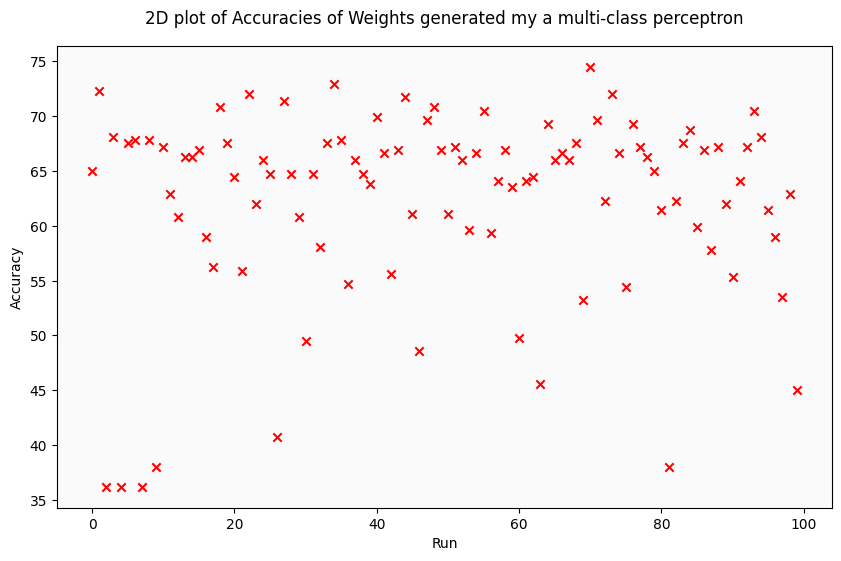

================================ACCURACY REPORT ON 100 RUNS============================
Mean: 62.42%
Variance: 73.92%
Standard Deviation: 8.6%
====================================ACCURACY REPORT END===============================


In [13]:
# test data on 100 runs - runtime: ~10s 
accuracies = []
runs = [i for i in range(0, 100)]
for run in runs:
    W = multiperceptron.fit(X, Y, False)
    accuracy, _ = multiperceptron.accuracy(W, X, Y)
    accuracies.append(accuracy)


# plot graph
fig2 = plt.figure(figsize=(10.0,6.0))
plt.scatter(runs, accuracies, marker = 'x', color = "red", label = "Accuracies")

ax = plt.gca()

ax.set_xlabel(r'Run')
ax.set_ylabel(r'Accuracy')
ax.set_title('2D plot of Accuracies of Weights generated my a multi-class perceptron',fontsize=12, y=1.03)
ax.set_facecolor('0.98')

plt.show()

# accuracy report
print("================================" +"ACCURACY REPORT ON 100 RUNS" + "============================")
# get mean and variance
mean = round(np.mean(accuracies), 2)
variance = round(np.var(accuracies), 2)
strd = round(np.std(accuracies), 2)

# print mean and variance
print("Mean: " + str(mean) + "%")
print("Variance: " + str(variance) + "%")
print("Standard Deviation: " + str(strd) + "%")
print("====================================" + "ACCURACY REPORT END" + "===============================")



From the figure shown above, from a 100 runs, it shows a range of accuracies ranging between 45% to 75%. It does not appear to want to go higher than that. With a mean accuracy of around 61% to 64% and a standard deviation of around 6% to 8%, it is safe to assume that getting a an accuracy of 100% is basically impossible under a normal distribution since the value is just around 5 standard deviations above the mean. From multiple personal runs, there has not been a single case where a run has an accuracy of 100%. Therefore it is safe to conclude that the data is not linearly separable in its original feature space defined with $12D$ feature vectors. 

### Implementing a Multi-Class Perceptron with Principal Components

In [14]:
def LinearPCAPerceptron(train, Y, k, verbose):

    # centre data
    scaled_train = train - np.mean(train, axis = 0)

    # decompose with SVD
    _, _, Vt = decompose(scaled_train)
    
    # obtaining the principal components of the k-th dimension
    P = scaled_train.to_numpy().dot(Vt.T)[:,:k]

    # call multi-class perceptron
    W = multiperceptron.fit(P, Y, False) 

    # customized error reporting
    if verbose:
        accuracy, _ = multiperceptron.accuracy(W, P, Y)
        if(accuracy == 100): 
            print("Dataset is linearly separable for k = " + str(k))
        else: 
            print("Dataset is not linearly separable for k = " + str(k) + ". Accuracy = " + str(accuracy) + "%")

    return W, P

Our function above decomposes the training data by SVD and obtains the training data, before utilising the previously described implementation of a multi-class perceptron.

### Training the dataset in all possible feature spaces defined by linear PCA

Instead of feeding the original ${12D}$ feature matrix as an input to our multi-class perceptron, we will input the dataset projected on $k$ principal vectors.

In [15]:
print("====================================" + "TRAINING BEGIN" + "====================================")

# data stores
means = []
variances = []
standard_deviations = []

# variable stores
linear_separable = False
k_linear = -1
test_linear = -1
maxAcc = 0
minAcc = 100

for dimension in range(2, 13):

   # accuracy storage
   accuracies = []

   # run 100 tests - Runtime : 1 - 2 mins
   for test in range(0, 100):
      W, P = LinearPCAPerceptron(train, Y, dimension, False)
      accuracy, _ = multiperceptron.accuracy(W, P, Y)
      accuracies.append(accuracy)
      maxAcc = max(maxAcc, accuracy)
      minAcc = min(minAcc, accuracy)
      if accuracy == 100 and linear_separable == False:
         linear_separable = True
         k_linear = dimension
         test_linear = test

   # obtaining statistical data
   mean = round(np.mean(accuracies), 2)
   variance = round(np.var(accuracies, axis = 0), 2)
   strd = round(np.std(accuracies, axis = 0), 2)
   print("k = " + str(dimension) + " -> Mean: " + str(mean) + "%\tVariance: " + str(variance) + "%\tStandard Deviation: " + str(strd) + "%")

   # append data to data stores
   means.append(mean)
   variances.append(variance)
   standard_deviations.append(strd)

# obtain gradients
mean_gradient, _ = np.polyfit([i for i in range(1, len(means) + 1)], means, 1)
variance_gradient, _ = np.polyfit([i for i in range(1, len(variances) + 1)], variances, 1)
strd_gradient, _ = np.polyfit([i for i in range(1, len(standard_deviations) + 1)], standard_deviations, 1)

# round gradients
mean_gradient = round(mean_gradient, 2)
variance_gradient = round(variance_gradient, 2)
strd_gradient = round(strd_gradient, 2)

# print overall report
print("\nOVERALL REPORT")
print("Mean gradient: " + str(mean_gradient) + "%")
print("Variance gradient: " + str(variance_gradient) + "%" + "\tStandard deviation gradient: " + str(strd_gradient) + "%")
print("Minimum accuracy: " + str(minAcc) + "%\t\t Maximum accuracy = " +str(maxAcc) + "%")

if linear_separable:
   print("\n1ST INSTANCE OF LINEAR SEPARABILITY FOUND AT")
   print("k = " + str(k_linear))
   print("test number = " + str(test_linear))
else:
   print("Dataset is not linearly separable in a feature space generated by linear PCA")
print("REPORT END")

print("====================================" + "TRAINING END" + "======================================")

====================================TRAINING BEGIN====================================
k = 2 -> Mean: 38.35%	Variance: 50.45%	Standard Deviation: 7.1%
k = 3 -> Mean: 43.36%	Variance: 51.28%	Standard Deviation: 7.16%
k = 4 -> Mean: 45.19%	Variance: 46.56%	Standard Deviation: 6.82%
k = 5 -> Mean: 47.88%	Variance: 39.85%	Standard Deviation: 6.31%
k = 6 -> Mean: 48.5%	Variance: 33.08%	Standard Deviation: 5.75%
k = 7 -> Mean: 50.9%	Variance: 30.37%	Standard Deviation: 5.51%
k = 8 -> Mean: 52.21%	Variance: 31.66%	Standard Deviation: 5.63%
k = 9 -> Mean: 58.15%	Variance: 16.08%	Standard Deviation: 4.01%
k = 10 -> Mean: 61.24%	Variance: 27.31%	Standard Deviation: 5.23%
k = 11 -> Mean: 65.25%	Variance: 19.25%	Standard Deviation: 4.39%
k = 12 -> Mean: 68.35%	Variance: 15.85%	Standard Deviation: 3.98%

OVERALL REPORT
Mean gradient: 2.82%
Variance gradient: -3.71%	Standard deviation gradient: -0.33%
Minimum accuracy: 23.7%		 Maximum accuracy = 74.8%
Dataset is not linearly separable in a feature s

The report shown above shows various forms of data when performing 100 training runs on the dataset in all possible feature spaces defined by linear PCA. The mean accuracy shows a general upward trend with an increasing amount of principal compents. This is suported by the positive gradient the report finds for the mean accuracies. There is also a downward trend in variance and standard deviation, which means that it beyond any resonable doubt that the program will not ahieve a 100% accuracy for any $k$. This is further supported by the maximum accuracy found during the 100 tests not being 100%. Therefore it is safe to conclude that the dataset is not linearly separable in a feature space generated by linear PCA.

### Implementing a RBF kernel matrix function

In [16]:
def RBF_kernel(X, gamma):

    # centre X
    X = X - np.mean(X, axis = 0)

    # get number of examples
    n_examples = X.shape[0]

    # convert X to a numpy array
    X = X.to_numpy()

    # initialize K
    K = np.empty(shape = (n_examples, n_examples))
    for i in range(0, n_examples):
        for j in range(0, n_examples):
            diff = X[i] - X[j]
            K[i,j] = np.exp(-gamma * np.matmul(diff, diff))
    
    # normalise K
    A = np.full((K.shape[0], K.shape[1]), 1/n_examples)
    AK = np.matmul(A, K)
    K_normalised = K - AK - np.matmul(K, A) + np.matmul(AK, A)

    return K_normalised

### Implementation of a grid search

In [9]:
import seaborn as sns
import math

In [18]:
def grid_search(training_data, target_data):

    # define variables
    epsilon = 0.05
    Y = target_data.to_numpy()
    separable = False
    linear_separable = ""

    # obtain sigma_min and sigma_max
    vars = training_data.var().to_numpy()
    sigma_min = np.amin(vars)
    sigma_max = np.amax(vars)

    # obtain gama_min and gama_max
    gamma_min = math.floor((1/(2 * (sigma_max + epsilon))) * 100) / 100
    gamma_max = math.ceil((1/(2 * (sigma_min - epsilon))) * 100) / 100

    # initialize graph variables
    n_pcs = [pc for pc in range(13, training_data.shape[0] + 1)]
    gammas = [round(gamma, 2) for gamma in np.arange(gamma_min, gamma_max + 0.01, 0.01)]
    err_matrix = [] 
    
    # hyperparameter tuning
    print("\nERROR REPORT BEGIN")
    for gamma in gammas:

        # stores number of errors for every feature space defined at a particular gamma
        n_errs_k = []

        # obtain variables to generate feature space
        K_normalised = RBF_kernel(training_data, gamma)
        _, _, Vt = decompose(pd.DataFrame(K_normalised))

        # 'k' hyperparameter tuning
        for k in range(13, K_normalised.shape[0] + 1):
            Z = np.matmul(K_normalised, Vt.T[:, :k])
            W = multiperceptron.fit(Z, Y, False)
            _, n_errs = multiperceptron.accuracy(W, Z, Y)

            # report at first instance of linear separability
            if n_errs == 0 and not separable:
                linear_separable = "\nLINEAR SEPARABILITY FOUND AT \n Min gamma = " + str(gamma) + " \n Min Top PCs = " + str(k)
                separable = True

            n_errs_k.append(n_errs)

        # print gradient and variance of errors generate at a certain gamma
        gradient, _ = np.polyfit([i for i in range(1, len(n_errs_k) + 1)], n_errs_k, 1)
        gradient = round(gradient, 2)
        variance = round(np.var(n_errs_k, axis = 0), 2)
        print("GAMMA: " + str(gamma) +" -> Error Gradient: " + str(gradient) + ". Error Variance: " + str(variance))

        err_matrix.append(n_errs_k)
        
    print("ERROR REPORT END")

    # report if dataset is not linearly separable in a non-linear feature space
    if(not separable):
        print("\nDataset is not linearly separable in a non-linear feature space")
    else:
        print(linear_separable)

    return gammas, n_pcs, err_matrix

The function exhaustively runs the multi-class perceptron for the ranges of $\gamma$ and $k$ to try to find out if the dataset is linearly separable in a non-linear feature space. If for some $\gamma$ and $k$, the weights generated by the multi-class perceptron produces 0 errors when testing against the training data, the data set is indeed linearly separable in a feature space generated by non-linear PCA. If the dataset is linearly separable, it will only notify the user at the minimum values of $\gamma$ and $k$. It will also produce an error report at each $\gamma$, reporting the variance and gradient of errors produced by the weights generated by the multi-class perceptron.

In [19]:
print("====================================" + "GRID SEARCH BEGIN" + "====================================")
gammas, n_pcs, err_matrix = grid_search(train, target) # runtime: 3 - 5 mins
print("====================================" + "GRID SEARCH END" + "======================================")

====================================GRID SEARCH BEGIN====================================

ERROR REPORT BEGIN
GAMMA: 0.01 -> Error Gradient: -0.05. Error Variance: 234.04
GAMMA: 0.02 -> Error Gradient: -0.1. Error Variance: 279.58
GAMMA: 0.03 -> Error Gradient: -0.12. Error Variance: 303.09
GAMMA: 0.04 -> Error Gradient: -0.15. Error Variance: 443.56
GAMMA: 0.05 -> Error Gradient: -0.19. Error Variance: 755.77
GAMMA: 0.06 -> Error Gradient: -0.23. Error Variance: 877.59
GAMMA: 0.07 -> Error Gradient: -0.25. Error Variance: 997.65
GAMMA: 0.08 -> Error Gradient: -0.31. Error Variance: 1360.32
GAMMA: 0.09 -> Error Gradient: -0.36. Error Variance: 1789.84
ERROR REPORT END

LINEAR SEPARABILITY FOUND AT 
 Min gamma = 0.05 
 Min Top PCs = 296
====================================GRID SEARCH END======================================


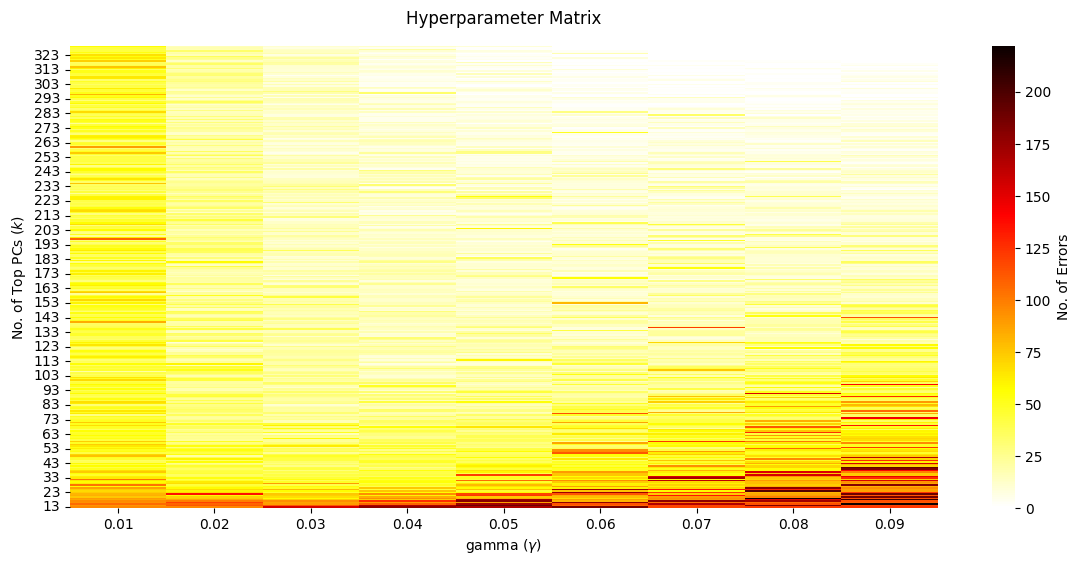

In [20]:
# plotting the results of a heatmap 
errs_df = pd.DataFrame(np.array(err_matrix).T, index = n_pcs,columns = gammas)
f,ax = plt.subplots(figsize=(14.0, 6.0))
sns.heatmap(errs_df, cbar_kws={'label': 'No. of Errors'}, cmap="hot_r", ax = ax)
ax.set_xlabel("gamma ($\gamma$)")
ax.set_ylabel("No. of Top PCs ($k$)")
ax.set_title('Hyperparameter Matrix',fontsize=12, y=1.03)

ax.invert_yaxis()
plt.show()

The hyperparameter matrix showcased above visualises the relationship between the number of errors generated on a feature space generated by the two hypermaramers and the values of the hyperparameters themselves. From a personal record of 40 runs, the data becomes linearly separable at 0.04 $\leq$ $\gamma$ $\leq$ 0.05 with a feature space defined by a range of feature spaces defined by 270 $\leq$ $k$ $\leq$ 330. Since the grid search obtained linear separability for some $k$ and $\gamma$ in all 40 tests, it is safe to conclude that the dataset is linearly separable in a feature space generated by non-linear PCA. The error report generated above shows that as $\gamma$ increases, the gradient on the errors increases in absolute values, whilst being negative overall. This means that as $\gamma$ increases, the number of errors generally decreases in higher-dimensional feature spaces. The error report also shows that the error varience also increases as $\gamma$ increases. This means that the 'spread' of accuracies is higher, which means that the multi-class perceptron produces a greater varience with increasing values of its features. 